In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 723.1/723.1 kB 18.6 MB/s eta 0:00:0000:01


In [2]:
import ultralytics
from ultralytics import YOLO
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import wandb
wandb.init(mode="disabled")
import shutil

In [3]:
if os.path.exists('dataset'):
    shutil.rmtree('dataset')
shutil.copytree('/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/', 'dataset')

'dataset'

In [4]:
files = os.listdir('dataset/images/train')
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]
print(random_file)

00271_134


(256, 192, 3)


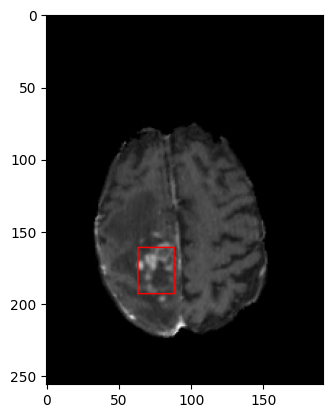

In [5]:
with open(os.path.join('dataset/labels/train', f'{random_file}.txt'),'r') as f:
    labels = f.readlines()
    labels = labels[0].split(' ')
    f.close()

img = cv2.imread(os.path.join('dataset/images/train', f'{random_file}.jpg'), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
x_pt1 = int((x - w/2) * img.shape[1])
y_pt1 = int((y - h/2) * img.shape[0])
x_pt2 = int((x + w/2) * img.shape[1])
y_pt2 = int((y + h/2) * img.shape[0])

if tumor_class == 1:
    colour = (255, 0, 0)
else:
    colour = (0, 255, 0)
cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)

print(img.shape)
plt.imshow(img)

In [6]:
train_images = os.listdir('dataset/images/train')
test_images = os.listdir('dataset/images/test')
train_labels = os.listdir('dataset/labels/train')
test_labels = os.listdir('dataset/labels/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

310 75
296 75


In [7]:
os.path.splitext(random_file)[0]
unlabelled = set(train_images) - set([os.path.splitext(file)[0] + '.jpg' for file in train_labels])

for image in unlabelled:
    os.remove(os.path.join('dataset/images/train', image))

In [8]:
train_images = os.listdir('dataset/images/train')
test_images = os.listdir('dataset/images/test')
train_labels = os.listdir('dataset/labels/train')
test_labels = os.listdir('dataset/labels/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

296 75
296 75


In [9]:
val_split = int(num_train_images * 0.2)
val_images = random.sample(train_images, val_split)

if os.path.exists('dataset/images/val'):
    shutil.rmtree('dataset/images/val')
if os.path.exists('dataset/labels/val'):
    shutil.rmtree('dataset/labels/val')

os.mkdir('./dataset/images/val')
os.mkdir('./dataset/labels/val')

for image in val_images:
    shutil.move(os.path.join('dataset/images/train', image), 'dataset/images/val')

for image in val_images:
    label = os.path.splitext(image)[0] + '.txt'
    shutil.move(os.path.join('dataset/labels/train', label), 'dataset/labels/val')

In [10]:
text = """
path: /kaggle/working/dataset
train: images/train
val: images/val

# Classes
nc: 2
names: ['negative','positive']
"""
with open("./fixed_path.yaml", 'w') as file:
    file.write(text)

In [11]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 141MB/s]


In [12]:
results = model.train(data='/kaggle/working/fixed_path.yaml', epochs=200, device=0)

Ultralytics YOLOv8.1.35 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/fixed_path.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

100%|██████████| 755k/755k [00:00<00:00, 21.6MB/s]
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/dataset/labels/train... 237 images, 0 backgrounds, 0 corrupt: 100%|██████████| 237/237 [00:00<00:00, 1273.35it/s]

train: New cache created: /kaggle/working/dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/dataset/labels/val... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<00:00, 1645.07it/s]

val: New cache created: /kaggle/working/dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      2.37G       1.62      4.406      1.403         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all         59         62    0.00299      0.822     0.0679     0.0414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      2.39G      1.224      2.998      1.127         27        640: 100%|██████████| 15/15 [00:02<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]

                   all         59         62    0.00241      0.647       0.21      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.39G      1.202      2.533      1.134         35        640: 100%|██████████| 15/15 [00:02<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]

                   all         59         62    0.00229      0.638       0.24      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      2.39G      1.142      2.315      1.107         29        640: 100%|██████████| 15/15 [00:02<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.98it/s]

                   all         59         62    0.00234      0.645      0.188      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      2.39G      1.196      2.213      1.106         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.49it/s]

                   all         59         62          1      0.053      0.398      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.39G      1.165      2.124      1.117         18        640: 100%|██████████| 15/15 [00:02<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

                   all         59         62      0.447      0.546      0.508      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      2.39G      1.185      2.146      1.179         27        640: 100%|██████████| 15/15 [00:02<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]

                   all         59         62      0.386      0.596      0.426       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      2.39G      1.177      1.916       1.13         22        640: 100%|██████████| 15/15 [00:02<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

                   all         59         62      0.461      0.473      0.416      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      2.39G      1.111      1.853      1.095         18        640: 100%|██████████| 15/15 [00:02<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.41it/s]

                   all         59         62       0.41      0.576      0.489      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      2.39G      1.252      1.785      1.137         31        640: 100%|██████████| 15/15 [00:02<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

                   all         59         62      0.492      0.556      0.485      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      2.39G      1.194      1.644      1.126         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

                   all         59         62      0.557      0.509      0.542      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      2.39G      1.144      1.517      1.127         26        640: 100%|██████████| 15/15 [00:02<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

                   all         59         62      0.613      0.719       0.71      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      2.39G      1.126      1.577      1.093         20        640: 100%|██████████| 15/15 [00:02<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

                   all         59         62      0.608      0.463      0.467       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      2.39G      1.144      1.494      1.091         18        640: 100%|██████████| 15/15 [00:02<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.41it/s]

                   all         59         62      0.505       0.62      0.595      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      2.39G      1.101      1.418      1.103         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.09it/s]

                   all         59         62      0.633      0.763      0.713      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.39G      1.113      1.469      1.116         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

                   all         59         62      0.621        0.5      0.593      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      2.39G      1.035      1.251      1.085         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

                   all         59         62      0.549      0.657      0.624      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      2.39G      1.114      1.284      1.078         27        640: 100%|██████████| 15/15 [00:02<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.16it/s]

                   all         59         62      0.604       0.71        0.7      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      2.39G      1.037      1.192      1.069         16        640: 100%|██████████| 15/15 [00:02<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

                   all         59         62      0.574      0.731      0.704      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      2.39G      1.054      1.113       1.06         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]

                   all         59         62      0.658      0.792      0.787      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      2.39G      1.003      1.125       1.03         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

                   all         59         62      0.665      0.692      0.768      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      2.39G      1.017      1.173      1.054         30        640: 100%|██████████| 15/15 [00:02<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

                   all         59         62      0.641      0.849      0.725      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      2.39G      1.013      1.135      1.048         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]

                   all         59         62      0.593      0.625      0.684      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      2.39G      1.003      1.119       1.04         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]

                   all         59         62      0.666      0.745      0.761      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      2.39G      1.008      1.059       1.06         30        640: 100%|██████████| 15/15 [00:02<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]

                   all         59         62      0.745      0.741      0.773       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      2.39G     0.9962     0.9912      1.017         27        640: 100%|██████████| 15/15 [00:02<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

                   all         59         62      0.628      0.664      0.667      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      2.39G     0.9759       0.99      1.014         20        640: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.93it/s]

                   all         59         62      0.714      0.823       0.83      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      2.39G     0.9801     0.9495      1.035         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

                   all         59         62      0.779      0.681      0.727      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      2.39G     0.9825     0.9125      1.048         24        640: 100%|██████████| 15/15 [00:02<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         59         62       0.51      0.768      0.613      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      2.39G      0.964     0.9661       1.03         21        640: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         59         62      0.614      0.839      0.759      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      2.39G      1.031      1.032      1.057         23        640: 100%|██████████| 15/15 [00:02<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]

                   all         59         62       0.71      0.722      0.695      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      2.39G     0.9641     0.9327      1.055         21        640: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

                   all         59         62      0.775      0.758      0.835      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      2.39G     0.9296     0.9007     0.9864         28        640: 100%|██████████| 15/15 [00:02<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

                   all         59         62      0.834      0.668      0.805      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      2.39G      0.968     0.8907      1.024         22        640: 100%|██████████| 15/15 [00:02<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]

                   all         59         62      0.779       0.78      0.858      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      2.39G     0.9337     0.8594      1.007         21        640: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.47it/s]

                   all         59         62      0.808      0.638      0.809      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      2.39G     0.9345      0.853      1.002         21        640: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

                   all         59         62      0.692      0.716      0.756      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      2.39G     0.9416     0.8272      1.014         18        640: 100%|██████████| 15/15 [00:02<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

                   all         59         62      0.743      0.751      0.761      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      2.39G     0.9636     0.8217      1.018         16        640: 100%|██████████| 15/15 [00:02<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

                   all         59         62      0.725      0.761      0.787      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      2.39G     0.9803     0.8255       1.05         26        640: 100%|██████████| 15/15 [00:02<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]

                   all         59         62      0.691      0.718      0.812      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      2.39G     0.9005      0.779      1.009         28        640: 100%|██████████| 15/15 [00:02<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.30it/s]

                   all         59         62      0.726        0.8      0.842       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      2.39G       0.86     0.7754      0.986         27        640: 100%|██████████| 15/15 [00:02<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]

                   all         59         62      0.788      0.748      0.843      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      2.39G      0.915     0.7885     0.9918         19        640: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]

                   all         59         62       0.72      0.701      0.737      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      2.39G     0.8909     0.7659     0.9994         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]

                   all         59         62       0.68      0.871      0.878      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      2.39G      0.879     0.7069     0.9845         20        640: 100%|██████████| 15/15 [00:02<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]

                   all         59         62      0.828       0.75      0.859      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      2.39G      0.853     0.6853     0.9823         16        640: 100%|██████████| 15/15 [00:02<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]

                   all         59         62      0.824      0.776      0.856      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      2.39G     0.9423     0.7365      1.002         23        640: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.02it/s]

                   all         59         62      0.595      0.854      0.773       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      2.39G     0.9256     0.7384     0.9925         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.96it/s]

                   all         59         62      0.751      0.776      0.862      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      2.39G     0.9118     0.7156     0.9941         20        640: 100%|██████████| 15/15 [00:02<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]

                   all         59         62      0.807      0.805      0.889      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      2.39G     0.8774     0.6767      0.983         19        640: 100%|██████████| 15/15 [00:02<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

                   all         59         62      0.873      0.784      0.889      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      2.39G      0.906     0.7216     0.9845         20        640: 100%|██████████| 15/15 [00:02<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.43it/s]

                   all         59         62      0.891      0.775      0.893      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      2.39G      0.908     0.6863     0.9836         24        640: 100%|██████████| 15/15 [00:02<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.32it/s]

                   all         59         62      0.811        0.8      0.849      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      2.39G     0.9228     0.7167     0.9999         21        640: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]

                   all         59         62      0.874      0.827      0.875      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      2.39G     0.8892      0.682     0.9933         18        640: 100%|██████████| 15/15 [00:02<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]

                   all         59         62      0.788      0.667      0.793      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      2.39G     0.8625     0.6661     0.9718         23        640: 100%|██████████| 15/15 [00:02<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.05it/s]

                   all         59         62      0.757      0.804      0.902      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      2.39G     0.8789      0.678     0.9719         17        640: 100%|██████████| 15/15 [00:02<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

                   all         59         62      0.792      0.805      0.836      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      2.39G     0.8575     0.7091     0.9885         27        640: 100%|██████████| 15/15 [00:02<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

                   all         59         62      0.745      0.909      0.907      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      2.39G     0.8821     0.7714     0.9797         21        640: 100%|██████████| 15/15 [00:02<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

                   all         59         62      0.638      0.743      0.733      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      2.39G     0.8747     0.7539     0.9722         20        640: 100%|██████████| 15/15 [00:02<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         59         62       0.77       0.76      0.804      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      2.39G     0.8204     0.6779     0.9597         28        640: 100%|██████████| 15/15 [00:02<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

                   all         59         62      0.741        0.9      0.879      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      2.39G     0.8195     0.6071      0.958         17        640: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

                   all         59         62       0.84      0.871      0.926      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      2.39G     0.8211     0.5959     0.9718         16        640: 100%|██████████| 15/15 [00:02<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]

                   all         59         62      0.736      0.905      0.906      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      2.39G     0.8057     0.6428     0.9541         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]

                   all         59         62       0.83      0.836      0.907      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      2.39G     0.8659     0.6414     0.9987         20        640: 100%|██████████| 15/15 [00:02<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

                   all         59         62      0.829      0.844       0.91      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      2.39G     0.8443     0.6129      0.976         26        640: 100%|██████████| 15/15 [00:02<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.87it/s]

                   all         59         62      0.859      0.745      0.878      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      2.39G     0.8506     0.5864     0.9582         26        640: 100%|██████████| 15/15 [00:02<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.03it/s]

                   all         59         62      0.716      0.764      0.797      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      2.39G     0.8055     0.6123     0.9694         22        640: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]

                   all         59         62       0.76      0.848      0.871      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      2.39G     0.8201     0.5897     0.9563         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.14it/s]

                   all         59         62       0.88      0.861      0.945      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      2.39G     0.8157     0.5898     0.9505         27        640: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.41it/s]

                   all         59         62      0.828      0.851      0.923      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      2.39G     0.8146     0.5495     0.9563         23        640: 100%|██████████| 15/15 [00:02<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.16it/s]

                   all         59         62      0.862      0.855      0.918      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      2.39G     0.7999     0.5932     0.9516         23        640: 100%|██████████| 15/15 [00:02<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]

                   all         59         62      0.724      0.835      0.875      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      2.39G      0.828     0.6084     0.9611         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

                   all         59         62      0.862      0.812      0.921      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      2.39G     0.7768     0.5796     0.9538         22        640: 100%|██████████| 15/15 [00:02<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.90it/s]

                   all         59         62      0.875      0.872       0.92      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      2.39G     0.8123     0.5617     0.9435         26        640: 100%|██████████| 15/15 [00:02<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

                   all         59         62      0.843      0.875      0.914      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      2.39G     0.8363     0.5839     0.9562         20        640: 100%|██████████| 15/15 [00:02<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]

                   all         59         62      0.851       0.84       0.94      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      2.39G     0.7913     0.5862     0.9525         18        640: 100%|██████████| 15/15 [00:02<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]

                   all         59         62      0.748      0.926      0.903      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      2.39G     0.8241     0.5736     0.9828         18        640: 100%|██████████| 15/15 [00:02<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.10it/s]

                   all         59         62      0.808       0.84      0.912      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      2.39G     0.7739     0.5919     0.9575         27        640: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]

                   all         59         62      0.716      0.816      0.856      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      2.39G     0.7642     0.5555      0.945         22        640: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]

                   all         59         62      0.716      0.892      0.837       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      2.39G     0.7656     0.5609     0.9374         26        640: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]

                   all         59         62      0.782      0.858      0.894      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      2.39G     0.7655     0.5315     0.9379         22        640: 100%|██████████| 15/15 [00:02<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.23it/s]

                   all         59         62      0.863      0.837      0.925      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      2.39G     0.8171     0.5578     0.9599         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]

                   all         59         62      0.897       0.76       0.85      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      2.39G     0.7974     0.5581     0.9567         23        640: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.96it/s]

                   all         59         62      0.929       0.85      0.945      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      2.39G     0.7744     0.5611     0.9689         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

                   all         59         62      0.887      0.797      0.865      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      2.39G     0.7967     0.5951     0.9674         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

                   all         59         62      0.918      0.828      0.918      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      2.39G     0.7817     0.5529     0.9454         20        640: 100%|██████████| 15/15 [00:02<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.31it/s]

                   all         59         62      0.895      0.822      0.915      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      2.39G     0.7412      0.543     0.9343         27        640: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

                   all         59         62      0.891      0.787      0.888      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      2.39G     0.7872     0.5361     0.9504         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

                   all         59         62      0.811      0.766      0.834      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      2.39G     0.7926      0.547     0.9554         25        640: 100%|██████████| 15/15 [00:02<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.02it/s]

                   all         59         62      0.783      0.772      0.815      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      2.39G     0.7558      0.541      0.952         22        640: 100%|██████████| 15/15 [00:02<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.41it/s]

                   all         59         62      0.779      0.869       0.89      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      2.39G     0.7688     0.5367     0.9678         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         59         62       0.74      0.884      0.839      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      2.39G     0.7566      0.565      0.939         20        640: 100%|██████████| 15/15 [00:02<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.10it/s]

                   all         59         62      0.765      0.857      0.837      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      2.39G     0.7339     0.5439     0.9383         22        640: 100%|██████████| 15/15 [00:02<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.36it/s]

                   all         59         62      0.785       0.73        0.8      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      2.39G     0.7417     0.5193     0.9434         22        640: 100%|██████████| 15/15 [00:02<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]

                   all         59         62      0.854       0.89      0.918      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      2.39G     0.7688     0.5805     0.9461         15        640: 100%|██████████| 15/15 [00:02<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

                   all         59         62       0.87      0.824      0.902       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      2.39G     0.7491     0.5168     0.9339         21        640: 100%|██████████| 15/15 [00:02<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]

                   all         59         62      0.809      0.868      0.901      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      2.39G     0.7759     0.5676     0.9518         20        640: 100%|██████████| 15/15 [00:02<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]

                   all         59         62      0.776      0.852      0.877      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      2.39G     0.7497     0.5239     0.9047         27        640: 100%|██████████| 15/15 [00:02<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

                   all         59         62      0.822      0.871      0.883       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      2.39G      0.719     0.4984     0.9349         32        640: 100%|██████████| 15/15 [00:02<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

                   all         59         62      0.742      0.768      0.847       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      2.39G     0.7037     0.4809     0.9368         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]

                   all         59         62      0.696      0.878      0.878       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      2.39G     0.7219     0.4841     0.9287         31        640: 100%|██████████| 15/15 [00:02<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

                   all         59         62      0.802      0.798      0.869      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      2.39G     0.6935     0.4821     0.9366         27        640: 100%|██████████| 15/15 [00:02<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

                   all         59         62      0.782      0.769      0.831      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      2.39G     0.7302     0.5199     0.9335         25        640: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.43it/s]

                   all         59         62      0.781      0.785       0.83      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      2.39G     0.6787     0.4679     0.9269         18        640: 100%|██████████| 15/15 [00:02<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.63it/s]

                   all         59         62      0.842      0.855      0.899       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      2.39G     0.7143     0.4613     0.9254         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

                   all         59         62      0.881      0.852      0.909      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      2.39G     0.7209     0.5024      0.936         24        640: 100%|██████████| 15/15 [00:02<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]

                   all         59         62      0.757      0.887       0.91      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      2.39G     0.6908     0.4939     0.9233         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.36it/s]

                   all         59         62      0.921      0.736      0.902      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      2.39G     0.7244     0.4852     0.9312         14        640: 100%|██████████| 15/15 [00:02<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]

                   all         59         62       0.75      0.831      0.881      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      2.39G     0.6686     0.4807     0.9159         26        640: 100%|██████████| 15/15 [00:02<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.30it/s]

                   all         59         62      0.811      0.854      0.901      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      2.39G     0.6959     0.4916     0.9085         25        640: 100%|██████████| 15/15 [00:02<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

                   all         59         62      0.764      0.893      0.912      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      2.39G     0.7027     0.4753     0.9235         29        640: 100%|██████████| 15/15 [00:02<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.47it/s]

                   all         59         62      0.872      0.804      0.904       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      2.39G     0.6718     0.4372     0.9088         23        640: 100%|██████████| 15/15 [00:02<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]

                   all         59         62       0.75      0.926      0.923      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      2.39G     0.6832     0.4712     0.9136         19        640: 100%|██████████| 15/15 [00:02<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]

                   all         59         62      0.791      0.921      0.937      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      2.39G     0.6851     0.4499     0.9179         24        640: 100%|██████████| 15/15 [00:02<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.67it/s]

                   all         59         62      0.875      0.787      0.902      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      2.39G     0.7016     0.4799     0.9119         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]

                   all         59         62        0.8      0.897      0.898      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      2.39G     0.6837     0.4552     0.9156         27        640: 100%|██████████| 15/15 [00:02<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]

                   all         59         62      0.902      0.849      0.932      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      2.39G     0.7047     0.4753     0.9276         29        640: 100%|██████████| 15/15 [00:02<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]

                   all         59         62      0.832       0.84      0.916      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      2.39G     0.7205     0.4726      0.937         24        640: 100%|██████████| 15/15 [00:02<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]

                   all         59         62      0.827      0.887      0.943      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      2.39G     0.7017     0.4544     0.9188         25        640: 100%|██████████| 15/15 [00:02<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         59         62      0.791      0.887      0.939      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      2.39G     0.6964     0.4696     0.9294         27        640: 100%|██████████| 15/15 [00:02<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]

                   all         59         62      0.854      0.839      0.903      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      2.39G      0.644     0.4411     0.8985         31        640: 100%|██████████| 15/15 [00:02<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]

                   all         59         62      0.877      0.802      0.918      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      2.39G     0.6739     0.4465     0.9125         19        640: 100%|██████████| 15/15 [00:02<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]

                   all         59         62      0.882      0.844      0.918      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      2.39G     0.6475     0.4548     0.8974         13        640: 100%|██████████| 15/15 [00:02<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]

                   all         59         62      0.883      0.802      0.919      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      2.39G     0.6589     0.4435     0.9212         22        640: 100%|██████████| 15/15 [00:02<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

                   all         59         62       0.74      0.891      0.903      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      2.39G      0.645     0.4374     0.9081         27        640: 100%|██████████| 15/15 [00:02<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.13it/s]

                   all         59         62      0.813      0.915      0.933      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      2.39G     0.6393     0.4173     0.9002         21        640: 100%|██████████| 15/15 [00:02<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.41it/s]

                   all         59         62      0.905      0.854      0.931      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      2.39G     0.6432      0.416     0.8967         20        640: 100%|██████████| 15/15 [00:02<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.73it/s]

                   all         59         62      0.908      0.862       0.94      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      2.39G      0.622      0.437     0.9009         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.20it/s]

                   all         59         62       0.92      0.678      0.881      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      2.39G     0.6128      0.406     0.8948         16        640: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

                   all         59         62      0.704      0.763      0.794      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      2.39G       0.61     0.3937     0.9016         21        640: 100%|██████████| 15/15 [00:02<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]

                   all         59         62       0.81      0.812      0.903      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      2.39G     0.6692     0.4473     0.9055         18        640: 100%|██████████| 15/15 [00:02<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         59         62       0.85      0.818      0.907      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      2.39G     0.6198     0.4247     0.9019         24        640: 100%|██████████| 15/15 [00:02<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.11it/s]

                   all         59         62      0.808      0.857      0.888      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      2.39G     0.6175     0.4144     0.8959         22        640: 100%|██████████| 15/15 [00:02<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.11it/s]

                   all         59         62      0.774      0.868      0.891       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      2.39G     0.6292     0.3883     0.8927         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]

                   all         59         62      0.782      0.846      0.875      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      2.39G     0.6296     0.4109     0.9057         20        640: 100%|██████████| 15/15 [00:02<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]

                   all         59         62      0.843      0.861      0.917      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      2.39G     0.6153     0.3901     0.8997         26        640: 100%|██████████| 15/15 [00:02<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]

                   all         59         62       0.86       0.84      0.902      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      2.39G      0.652     0.4041     0.9138         27        640: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.22it/s]

                   all         59         62      0.874      0.853      0.931      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      2.39G     0.6143     0.3955     0.9096         21        640: 100%|██████████| 15/15 [00:02<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]

                   all         59         62      0.882      0.853      0.932      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      2.39G      0.617     0.4197     0.8882         21        640: 100%|██████████| 15/15 [00:02<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]

                   all         59         62      0.861      0.861      0.917      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      2.39G     0.6236     0.4186     0.8842         21        640: 100%|██████████| 15/15 [00:02<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]

                   all         59         62      0.832      0.842      0.906      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      2.39G      0.598     0.3951     0.9122         20        640: 100%|██████████| 15/15 [00:02<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.22it/s]

                   all         59         62      0.815      0.835      0.907      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      2.39G     0.6085     0.4132     0.9054         29        640: 100%|██████████| 15/15 [00:02<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.36it/s]

                   all         59         62      0.808      0.861      0.903      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      2.39G     0.6191     0.4131     0.8981         27        640: 100%|██████████| 15/15 [00:02<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]

                   all         59         62      0.871      0.909      0.936      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      2.39G     0.6402     0.4691     0.9218         19        640: 100%|██████████| 15/15 [00:02<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.02it/s]

                   all         59         62      0.807      0.887      0.901      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      2.39G     0.6005     0.4046     0.8898         27        640: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.36it/s]

                   all         59         62      0.822      0.905      0.904      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      2.39G     0.6031      0.412     0.9002         21        640: 100%|██████████| 15/15 [00:02<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

                   all         59         62      0.828      0.887      0.932      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      2.39G     0.6307     0.3965     0.9008         25        640: 100%|██████████| 15/15 [00:02<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]

                   all         59         62      0.872      0.886      0.948      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      2.39G      0.623     0.4024     0.9019         27        640: 100%|██████████| 15/15 [00:02<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

                   all         59         62      0.838      0.925      0.962      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      2.39G     0.6028     0.3982      0.914         17        640: 100%|██████████| 15/15 [00:02<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.12it/s]

                   all         59         62      0.884      0.909      0.964      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      2.39G     0.5601      0.378     0.8732         25        640: 100%|██████████| 15/15 [00:02<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]

                   all         59         62      0.895      0.913      0.961      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      2.39G     0.5954     0.3925     0.8862         28        640: 100%|██████████| 15/15 [00:02<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

                   all         59         62      0.885      0.887      0.955      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      2.39G     0.5848     0.3842     0.8935         20        640: 100%|██████████| 15/15 [00:02<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.89it/s]

                   all         59         62      0.865      0.875      0.953      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      2.39G     0.6134     0.3971     0.9169         27        640: 100%|██████████| 15/15 [00:02<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

                   all         59         62      0.881      0.908      0.949      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      2.39G     0.5925     0.3986     0.8937         25        640: 100%|██████████| 15/15 [00:02<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         59         62      0.859      0.907      0.938        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      2.39G     0.5896     0.3889     0.8952         24        640: 100%|██████████| 15/15 [00:02<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

                   all         59         62      0.895       0.88      0.938      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      2.39G     0.5591     0.3778     0.8731         22        640: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]

                   all         59         62      0.885      0.851      0.918      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      2.39G     0.5674     0.3744     0.8778         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.31it/s]

                   all         59         62       0.94      0.793      0.931      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      2.39G     0.5678     0.3805     0.8999         23        640: 100%|██████████| 15/15 [00:02<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]

                   all         59         62      0.843      0.922      0.945      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      2.39G     0.5177     0.3451     0.8639         22        640: 100%|██████████| 15/15 [00:02<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]

                   all         59         62      0.893      0.861      0.941      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      2.39G     0.5628      0.376     0.8696         28        640: 100%|██████████| 15/15 [00:02<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]

                   all         59         62      0.866      0.916      0.959      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      2.39G     0.5778     0.3777     0.8996         29        640: 100%|██████████| 15/15 [00:02<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.43it/s]

                   all         59         62      0.821      0.919      0.947      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      2.39G     0.5437     0.3681     0.8813         17        640: 100%|██████████| 15/15 [00:02<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

                   all         59         62      0.796      0.887      0.937      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      2.39G     0.5532      0.351     0.8794         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

                   all         59         62      0.848      0.853      0.907      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      2.39G     0.5635     0.3671     0.8968         20        640: 100%|██████████| 15/15 [00:02<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]

                   all         59         62      0.801      0.909      0.931      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      2.39G     0.5299     0.3544     0.8703         25        640: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]

                   all         59         62      0.834      0.887      0.952      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      2.39G     0.5442     0.3732     0.8825         29        640: 100%|██████████| 15/15 [00:02<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]

                   all         59         62      0.857      0.909      0.947      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      2.39G     0.5339     0.3659     0.8815         19        640: 100%|██████████| 15/15 [00:02<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

                   all         59         62      0.879      0.887      0.951      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      2.39G     0.5461     0.3594     0.8699         20        640: 100%|██████████| 15/15 [00:02<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]

                   all         59         62       0.82      0.941      0.953      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      2.39G     0.5561     0.3585     0.9021         21        640: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]

                   all         59         62      0.881      0.908      0.954      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      2.39G     0.5182     0.3549     0.8601         25        640: 100%|██████████| 15/15 [00:02<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.16it/s]

                   all         59         62      0.849      0.907      0.943        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      2.39G     0.5457     0.3643     0.8839         24        640: 100%|██████████| 15/15 [00:02<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]

                   all         59         62      0.918      0.857      0.942      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      2.39G     0.5184     0.3486     0.8683         29        640: 100%|██████████| 15/15 [00:02<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

                   all         59         62      0.872      0.853       0.94      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      2.39G     0.5326     0.3477     0.8736         19        640: 100%|██████████| 15/15 [00:02<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.27it/s]

                   all         59         62      0.916      0.896      0.969       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      2.39G     0.5424     0.3542     0.8856         18        640: 100%|██████████| 15/15 [00:02<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]

                   all         59         62      0.938      0.918       0.98      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      2.39G     0.5597     0.3754      0.903         25        640: 100%|██████████| 15/15 [00:02<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

                   all         59         62      0.933      0.897      0.976      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      2.39G     0.5082     0.3434     0.8582         20        640: 100%|██████████| 15/15 [00:02<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]

                   all         59         62      0.915      0.895      0.969      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      2.39G     0.5258     0.3452     0.8784         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]

                   all         59         62      0.864      0.905      0.936       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      2.39G     0.5325     0.3524     0.8778         29        640: 100%|██████████| 15/15 [00:02<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

                   all         59         62      0.884      0.907      0.938        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      2.39G     0.4923     0.3358     0.8563         17        640: 100%|██████████| 15/15 [00:02<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

                   all         59         62      0.897      0.908      0.962      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      2.39G     0.5124     0.3341     0.8818         28        640: 100%|██████████| 15/15 [00:02<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]

                   all         59         62      0.875      0.918      0.953      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      2.39G     0.5498     0.3692     0.8915         21        640: 100%|██████████| 15/15 [00:02<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]

                   all         59         62      0.882      0.904       0.95      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      2.39G     0.5472     0.3572     0.8871         18        640: 100%|██████████| 15/15 [00:02<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]

                   all         59         62      0.844      0.933      0.946      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      2.39G     0.5193     0.3454     0.8722         25        640: 100%|██████████| 15/15 [00:02<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

                   all         59         62      0.892      0.917      0.955      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      2.39G     0.5055      0.339     0.8702         21        640: 100%|██████████| 15/15 [00:02<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]

                   all         59         62      0.894      0.921      0.964      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      2.39G      0.504     0.3377      0.872         31        640: 100%|██████████| 15/15 [00:02<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.17it/s]

                   all         59         62      0.909       0.88      0.956      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      2.39G     0.5018     0.3309     0.8647         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

                   all         59         62      0.911      0.866      0.938      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      2.39G     0.4793     0.3215     0.8507         27        640: 100%|██████████| 15/15 [00:02<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.04it/s]

                   all         59         62      0.879      0.866      0.927      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      2.39G     0.5037     0.3323     0.8815         14        640: 100%|██████████| 15/15 [00:02<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         59         62      0.899      0.861      0.933      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      2.39G     0.5002     0.3305     0.8681         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]

                   all         59         62      0.871      0.867      0.936      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      2.39G     0.4815      0.336     0.8644         28        640: 100%|██████████| 15/15 [00:02<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

                   all         59         62      0.943      0.805      0.943      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      2.39G     0.5021     0.3283     0.8748         20        640: 100%|██████████| 15/15 [00:02<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]

                   all         59         62      0.863        0.9      0.951      0.705


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      2.39G      0.426     0.2773     0.8226         13        640: 100%|██████████| 15/15 [00:03<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

                   all         59         62      0.855      0.914       0.96      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      2.39G     0.4183     0.2718     0.8105         13        640: 100%|██████████| 15/15 [00:02<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

                   all         59         62      0.981      0.817      0.965      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      2.39G     0.4041     0.2747     0.8224         15        640: 100%|██████████| 15/15 [00:02<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

                   all         59         62      0.867      0.901      0.964      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      2.39G     0.4104      0.266     0.8192         14        640: 100%|██████████| 15/15 [00:02<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.04it/s]

                   all         59         62      0.866      0.905      0.962      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      2.39G     0.3851     0.2524     0.8134         14        640: 100%|██████████| 15/15 [00:02<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         59         62      0.865      0.905      0.964      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      2.39G     0.3942     0.2597       0.81         13        640: 100%|██████████| 15/15 [00:02<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.41it/s]

                   all         59         62      0.873      0.896      0.959      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      2.39G     0.4017     0.2522     0.8196         14        640: 100%|██████████| 15/15 [00:02<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.52it/s]

                   all         59         62      0.868      0.906      0.956      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      2.39G     0.3712     0.2504     0.7956         14        640: 100%|██████████| 15/15 [00:02<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]

                   all         59         62       0.87        0.9      0.957      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      2.39G     0.3751     0.2521     0.8124         14        640: 100%|██████████| 15/15 [00:02<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

                   all         59         62      0.871      0.907      0.958      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      2.39G     0.3709     0.2508     0.7988         14        640: 100%|██████████| 15/15 [00:02<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         59         62       0.87      0.907      0.959      0.731



200 epochs completed in 0.210 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.35 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]


                   all         59         62      0.915      0.896      0.969      0.733
              negative         59         23      0.907       0.87      0.966      0.711
              positive         59         39      0.924      0.923      0.971      0.754
Speed: 2.2ms preprocess, 1.8ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/train


In [13]:
#print(results)

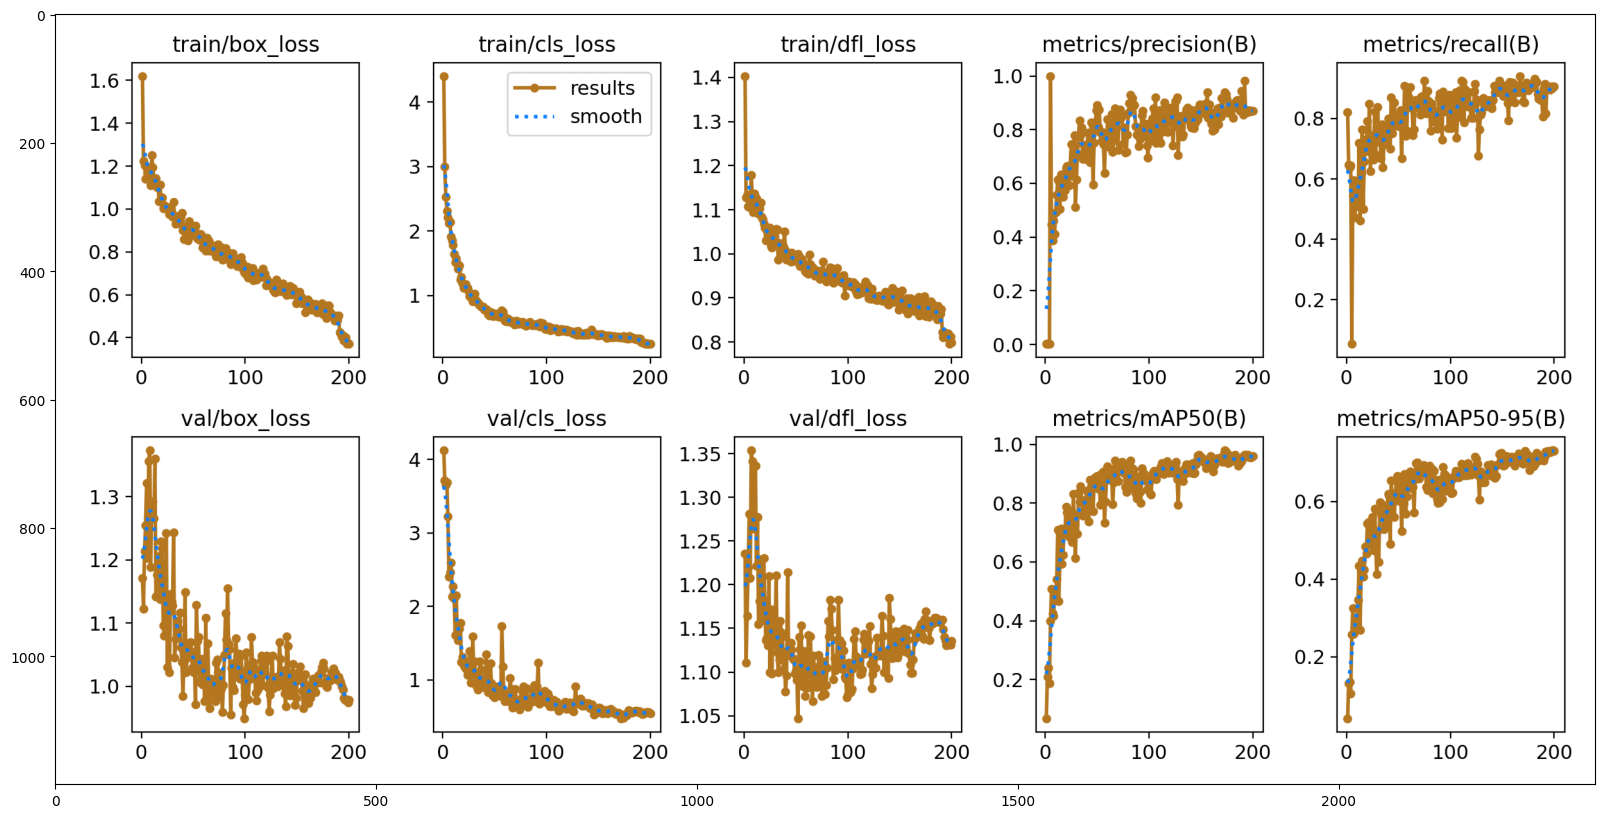

In [14]:
training_save_dir = '/kaggle/working/' + str(results.save_dir)

plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'results.png'))
plt.imshow(img)
plt.show()

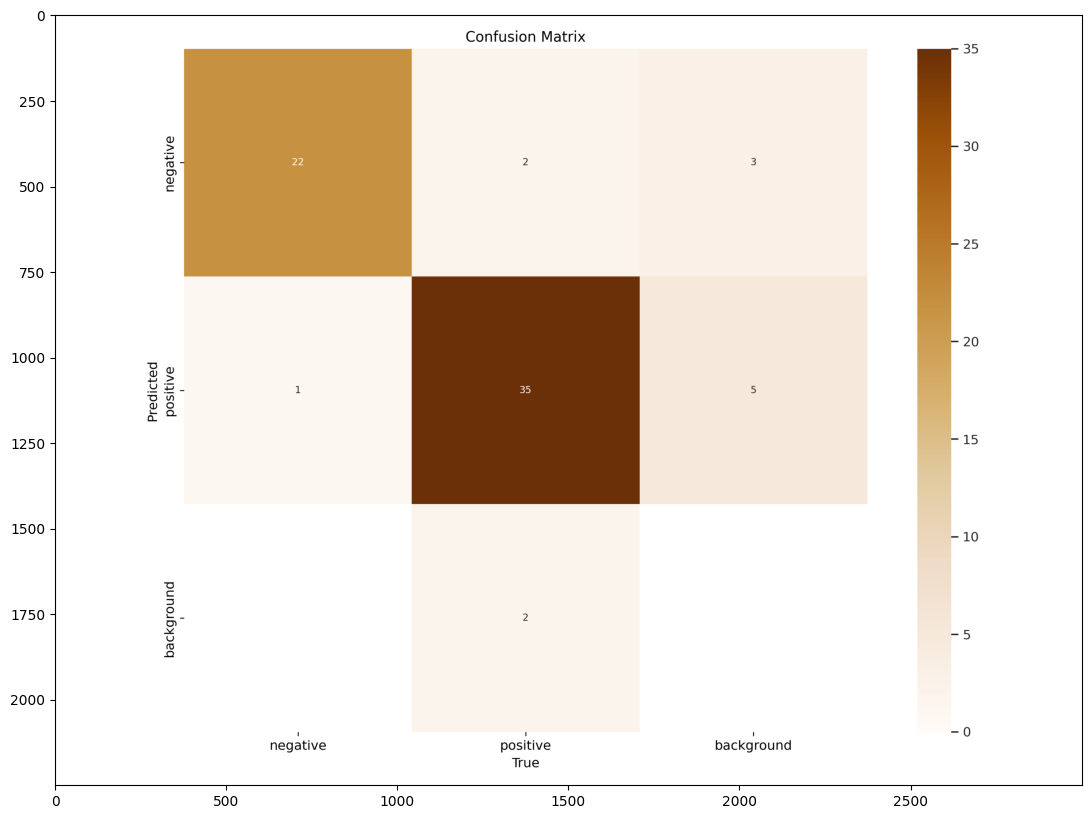

In [15]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

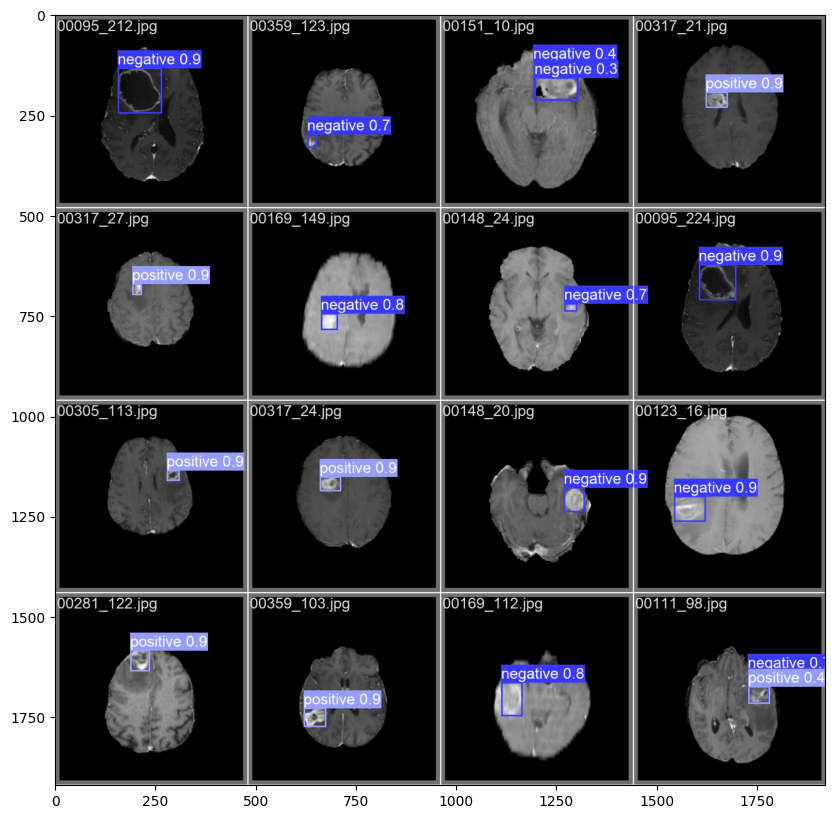

In [16]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

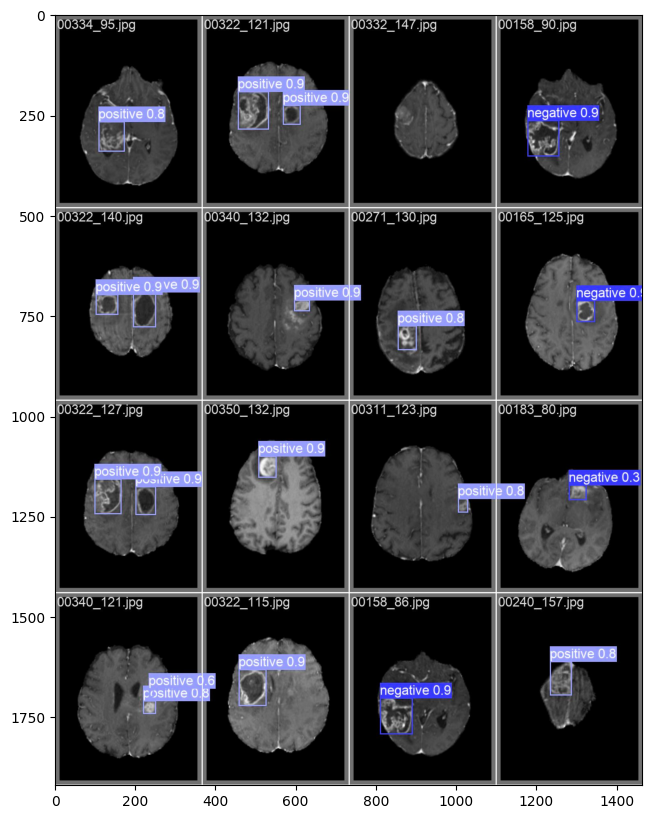

In [17]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()

In [18]:
trained_model = YOLO(training_save_dir + '/weights/best.pt')
predictions = trained_model.predict(
    source="/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test",
    conf=0.4, save_txt=True, save_conf=True)


image 1/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_101.jpg: 640x640 1 negative, 5.7ms
image 2/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_109.jpg: 640x640 1 negative, 5.7ms
image 3/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_111.jpg: 640x640 1 negative, 5.5ms
image 4/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_117.jpg: 640x640 1 negative, 5.9ms
image 5/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_121.jpg: 640x640 1 negative, 6.4ms
image 6/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_126.jpg: 640x640 1 negative, 6.2ms
image 7/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_134.jpg: 640x640 (no detections), 6.2ms
image 8/75 /kaggle/input/brain-tumor-objec

In [19]:
#print(predictions[4])

In [20]:
predictions_save_dir = '/kaggle/working/' + predictions[0].save_dir + '/labels'

In [21]:
def draw_bbox(file_path, filename, img):
    with open(os.path.join(file_path, f'{filename}.txt'),'r') as f:
        labels = f.readlines()
        labels = labels[0].split(' ')
        print(labels)
        f.close()

    tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
    x_pt1 = int((x - w/2) * img.shape[1])
    y_pt1 = int((y - h/2) * img.shape[0])
    x_pt2 = int((x + w/2) * img.shape[1])
    y_pt2 = int((y + h/2) * img.shape[0])

    if tumor_class == 0:
        colour = (255, 0, 0)
        label = 'Negative'
    else:
        colour = (0, 255, 0)
        label = 'Positive'
    if len(labels) > 5:
        prob = float(labels[5])
        prob = round(prob, 1)
        prob = str(prob)
        label = label + ' ' + prob

    cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)
    cv2.putText(img, label, (x_pt1, y_pt1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, colour, 1)

['0', '0.681468', '0.555431', '0.051363', '0.0460707', '0.8034\n']
['0', '0.680751', '0.555751', '0.058685', '0.048122']


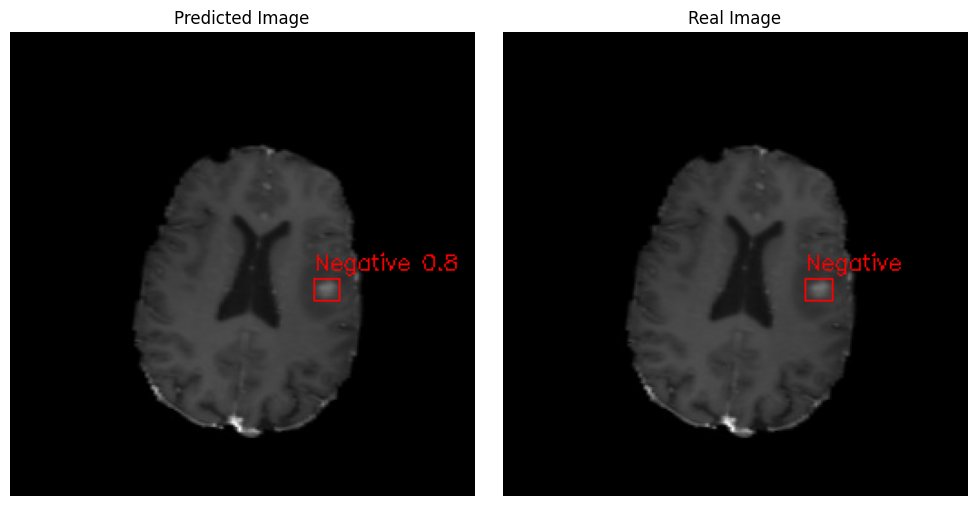

In [22]:
files = os.listdir(predictions_save_dir)
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]

img_pred = cv2.imread(os.path.join('dataset/images/test', f'{random_file}.jpg'), 1)
img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
draw_bbox(predictions_save_dir, random_file, img_pred)

img_real = cv2.imread(os.path.join('dataset/images/test', f'{random_file}.jpg'), 1)
img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
draw_bbox('dataset/labels/test', random_file, img_real)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_pred)
axes[0].set_title('Predicted Image')
axes[0].axis('off')

axes[1].imshow(img_real)
axes[1].set_title('Real Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [23]:
text = """
path: /kaggle/working/dataset
train: images/train
val: images/test

# Classes
nc: 2
names: ['negative','positive']
"""
with open("./test.yaml", 'w') as file:
    file.write(text)

In [24]:
metrics = trained_model.val(data="test.yaml")  # no arguments needed, dataset and settings remembered

Ultralytics YOLOv8.1.35 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)


val: Scanning /kaggle/working/dataset/labels/test... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<00:00, 1277.67it/s]

val: New cache created: /kaggle/working/dataset/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


                   all         75         81      0.823       0.84      0.891      0.657
              negative         75         81      0.823       0.84      0.891      0.657
Speed: 3.6ms preprocess, 5.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val


In [25]:
test_save_dir = '/kaggle/working/' + str(metrics.save_dir)

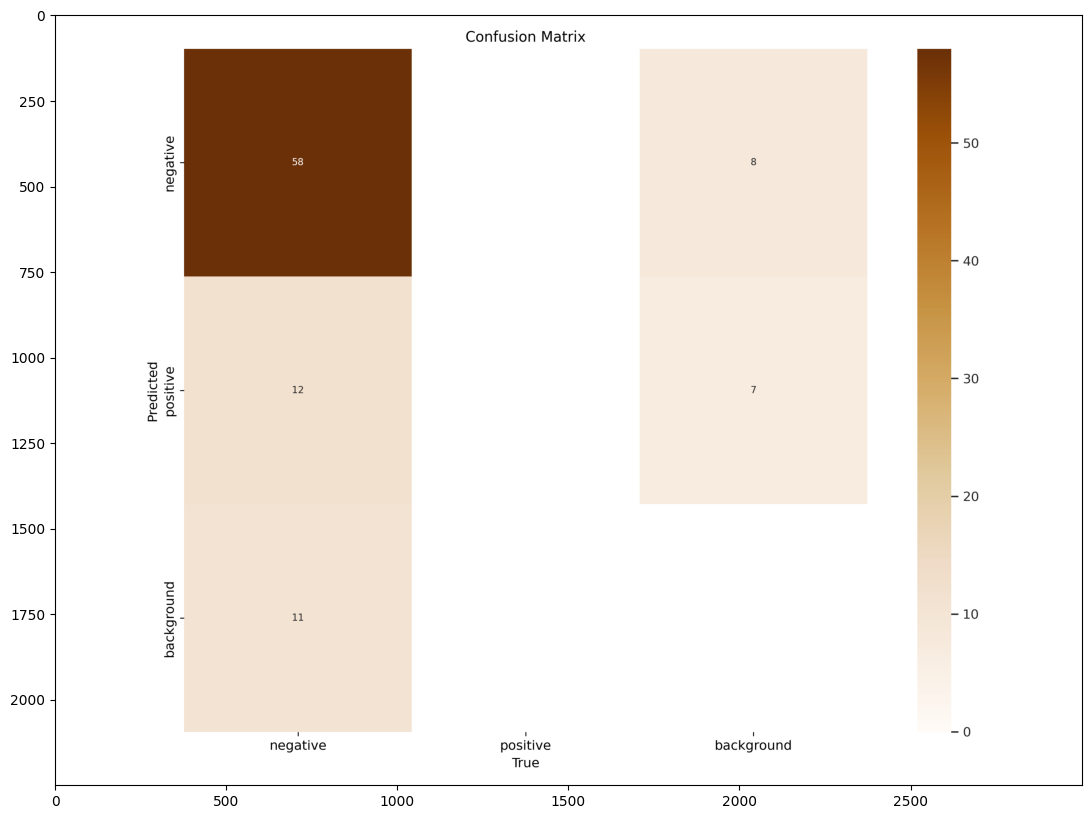

In [26]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

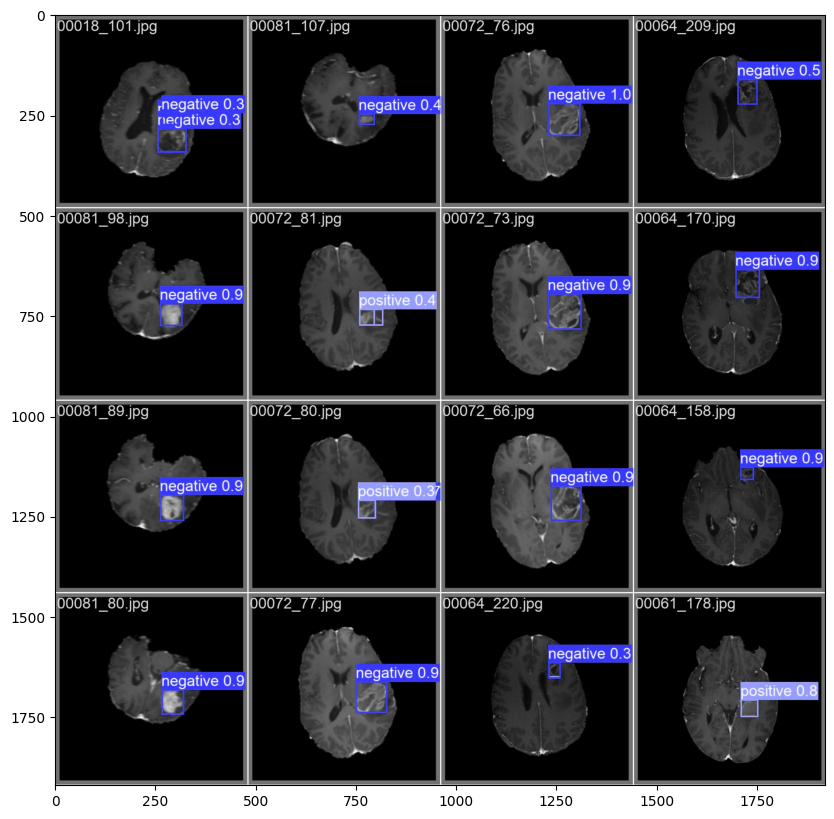

In [27]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

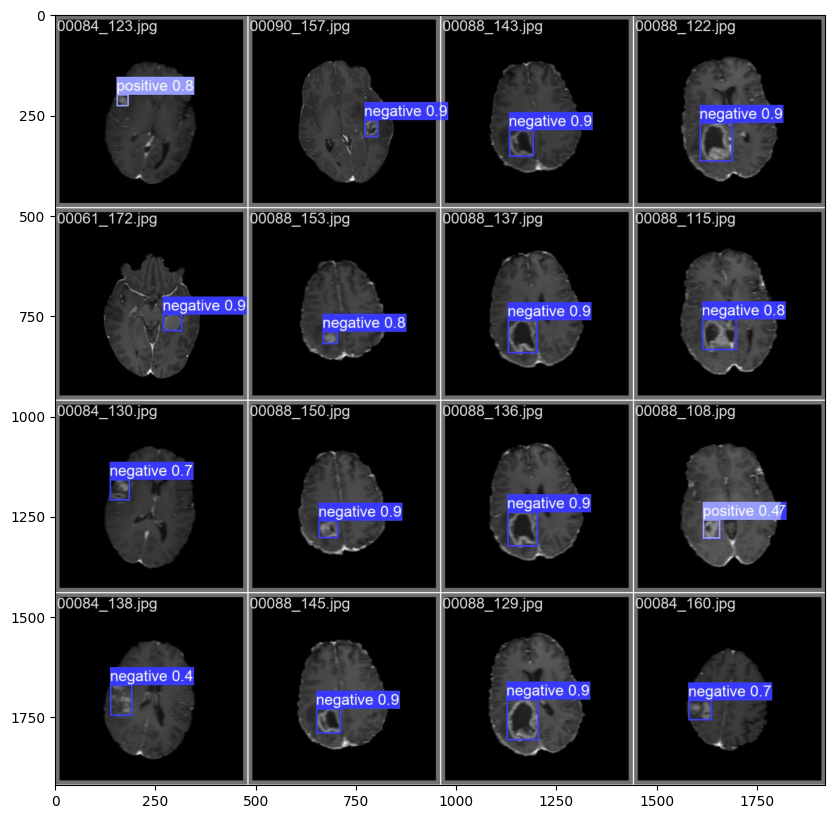

In [28]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()